<a href="https://colab.research.google.com/github/rakaboss98-gx/SAR_CSA/blob/main/Chirp_Scaling_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("./gdrive",force_remount=True)
%cd "./gdrive/My Drive/SAR_IITB/Data/"
!ls -l

Mounted at ./gdrive
/content/gdrive/My Drive/SAR_IITB/Data
total 448291
-rw------- 1 root root  70512798 Jan 25 07:54 data.csv
-rw------- 1 root root  34015515 Jan 25 08:53 imaginary_part.csv
-rw------- 1 root root 316728444 Jan 22 15:20 IMGDATA.DAT
-rw------- 1 root root     28228 Jan 22 17:05 LEADER.DAT
-rw------- 1 root root   2000284 Jan 25 09:28 my.png
-rw------- 1 root root  34010967 Jan 25 08:53 real_part.csv
-rw------- 1 root root   1751632 Jan 25 17:55 SAR_range_compressed.png


In [ ]:
import math
'Constants and sensor based parameters'
c = 3e8
pi = 3.14159
lambda1 = 0.0566
fc = c/lambda1 #Radar operating frequency

Tr = 3.712e-05 #Transmit pulse duration
Kr = 4.19e11 #Tuning frequency Hz/sec
alpha = 1 #Range oversampling factor
Fr = 18960000 #Sampling rate
rangeGateDelay = 0.0055
ro = rangeGateDelay*c/2

'Radar effective speed'
xBarVelocity  = 2221.77107 #xBar velocity in m/sec
yBarVelocity = 1963.30288 #yBar velocity in m/sec
zBarVelocity  = -6949.51836 #zBar velocity in m/sec
v = math.sqrt(xBarVelocity**2+yBarVelocity**2+zBarVelocity**2)
h = 790000 #platform attitude above ground m
Re = 6378144 #Radius of earth in m
Vr = v*(math.sqrt(Re/(Re+h)))

La = 10 #Antenna length
beta = 1 #Azimuth oversampling rate
PRF = 1679.9




'Data format Parameters'
Na = 2048
numBytes = 11644
numHdr = 412
nValid = (numBytes-numHdr)/2 - round(Tr*Fr) #Valid range samples
Nr = nValid

In [ ]:
import numpy as np
t_eta = np.linspace(-Na/2/PRF,Na/2/PRF,Na)
f_eta = np.linspace(-PRF/2,PRF/2,Na)
f_eta_ref = 163.14 #Doppler center frequency of the reference target
R_ref = ro
t_eta2=(t_eta[np.newaxis].T)*np.ones(int(Nr))

In [ ]:
tau=2*ro/c+np.linspace(-Nr/2/Fr,Nr/2/Fr,int(Nr))
tau2= (np.ones(Na)[np.newaxis].T)*tau
f_tau = np.linspace(-Fr/2,Fr/2,int(Nr))
f_tau2 = (np.ones(Na)[np.newaxis].T)*f_tau
dr=c/2*tau;

In [ ]:
'Combine the real and complex part of the image'
from numpy import genfromtxt
real_data = genfromtxt('real_part.csv', delimiter=',')
img_data = genfromtxt('imaginary_part.csv', delimiter=',')
data = real_data + 1j*img_data

#print(data.dtype)

'Save the raw image in 32bit integer format'
#d = np.absolute(data)
#from PIL import Image
#img = Image.fromarray(d, 'I')
#img.save('SAR_Raw.png')
'Remove Mean'
gamman = data - np.mean(data)

In [ ]:
'Removing the unnecessary data'
Nsample = int(nValid)
gamman_new = gamman[:,[i for i in range(0,Nsample)]]

In [ ]:
#Carry out the Fourier transform of the azimuth to get the range Doppler domain spectrum
srd = gamman_new*np.exp(-1j*2*pi*f_eta_ref*t_eta2)
Srd=np.fft.fftshift(np.fft.fft(np.fft.fftshift(srd),axis=0))


In [ ]:
'Radar data is transformed into range doppler domain'

D_f = np.sqrt(1-((lambda1**2)*((f_eta.T[np.newaxis].T)**2))/(4*(Vr**2))) #Migration factor coloumn vector
D_f_eta = D_f*np.ones(int(Nr)) #Matrix of size Na*Nr
D_f_eta_ref=np.sqrt(1-((lambda1**2)*(f_eta_ref**2)/(4*(Vr**2))))


In [ ]:
km_yin= 2*(Vr**2)*(fc**3)*(D_f**3)/(c*R_ref*(f_eta.T[np.newaxis].T)**2)*np.ones(int(Nr))
Km = Kr/(1-Kr/km_yin)

In [ ]:
'Scaling equation s_sc'
s_sc = np.exp(1j*pi*Km*(D_f_eta_ref/D_f_eta-1)*((tau2-2*R_ref/(c*D_f_eta))**2))


In [ ]:
'Next, multiply the signal in the range Doppler domain with the scaling equation to achieve "complementary RCMC"'
S1 = Srd*s_sc

In [ ]:
 'Perform range FFT and transform to two-dimensional frequency domain. Distance zero frequency at both ends'
S2=np.fft.fftshift(np.fft.fft(np.fft.fftshift(S1)))

In [ ]:
'The filters that complete the phase compensation of distance compression, SRC, and RCMC are'
s_sc2 = (np.exp(1j*pi*D_f_eta/(D_f_eta_ref*Km)*(f_tau2**2)))*np.exp(1j*4*pi/c*(1/D_f_eta-1/D_f_eta_ref)*R_ref*f_tau2)

In [ ]:
'In the two-dimensional frequency domain, phase multiplication to achieve distance compression, SRC, consistent RCMC'
S3 = S2*s_sc2

In [ ]:
S4 = np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(S3)))

In [ ]:
'Complete distance compression, SRC, consistent RCMC, distance Doppler domain'
H=np.exp(1j*4*pi*fc*(D_f*dr)/c) #Generate azimuth matched filter
H2=np.exp(-1j*4*pi*Km/(c**2)*(1-D_f_eta/D_f_eta_ref)) # Additional phase correction item


In [ ]:
'Next, perform phase multiplication, in the range Doppler domain, and complete the azimuth MF and additional phase correction at the same time'
S5 = S4*H*H2
s = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(S5),axis=0))

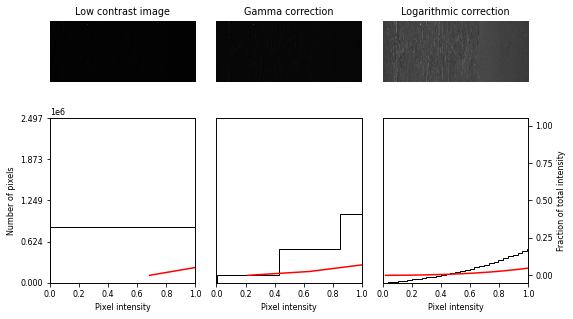

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure

matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = np.absolute(s)

# Gamma
gamma_corrected = exposure.adjust_gamma(img, 0.8)

# Logarithmic
logarithmic_corrected = exposure.adjust_log(img, 1)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 3), dtype=np.object)
axes[0, 0] = plt.subplot(2, 3, 1)
axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0])
axes[0, 2] = plt.subplot(2, 3, 3, sharex=axes[0, 0], sharey=axes[0, 0])
axes[1, 0] = plt.subplot(2, 3, 4)
axes[1, 1] = plt.subplot(2, 3, 5)
axes[1, 2] = plt.subplot(2, 3, 6)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(gamma_corrected, axes[:, 1])
ax_img.set_title('Gamma correction')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(logarithmic_corrected, axes[:, 2])
ax_img.set_title('Logarithmic correction')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

[imagesc] >WARNING: Plot will be poorly visible if [linewidth>0] with rows/columns>100. Set linewidth=0 to adjust. [auto-adjusting...]


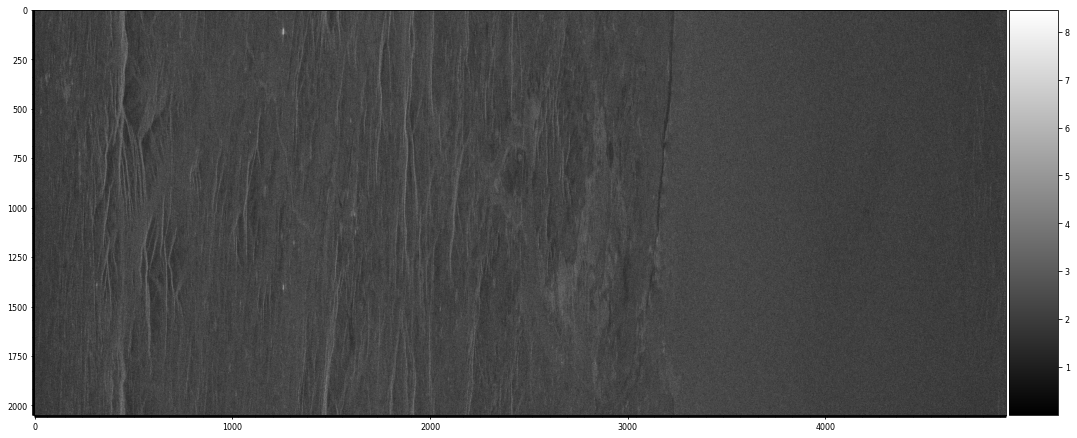

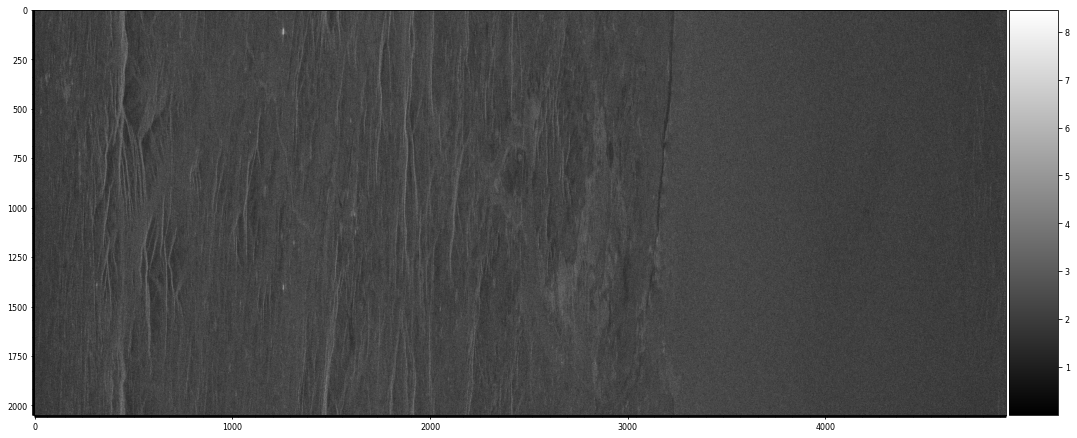

In [ ]:
 import imagesc
 imagesc.plot(logarithmic_corrected ,cmap='gray')


In [ ]:
!pip install imagesc

     |████████████████████████████████| 204kB 13.6MB/s 
